In [1]:
import pandas as pd
from sklearn import set_config
set_config(transform_output = "pandas")

# Import model specific code. Explicitly import custom preprocessing functions (i.e., extract_day_of_year)
from Ensemble_Functions import En_test_train_validation_split, load_constituent_models, load_constituent_pipelines, ModelPredictor, plot_roc_curve
from SVM.SVM_functions import SVM_predict, extract_day_of_year
from ANN.ANN_functions import ANN_predict_proba
from RF.RF_functions import RF_predict_proba

In [2]:
## Load models ##

models = load_constituent_models("ANN/ANN.h5","RF/RF.pkl","SVM/SVM.joblib")
ANN_model = models["ANN/ANN.h5"]
RF_model = models["RF/RF.pkl"]
SVM_model = models["SVM/SVM.joblib"]

pipelines = load_constituent_pipelines("ANN/ANN_pipeline.joblib","RF/RF_pipeline.joblib","SVM/SVM_pipeline.joblib")
ANN_pipeline = pipelines["ANN/ANN_pipeline.joblib"]
RF_pipeline = pipelines["RF/RF_pipeline.joblib"]
SVM_pipeline = pipelines["SVM/SVM_pipeline.joblib"]

# Freeze the ANN model
for layer in ANN_model.layers:
    layer.trainable = False

In [3]:
## Load and split data ##

# Load wildfire dataframe and perform simple preprocessing
#main_df = pd.read_csv("downsampled_df.csv",index_col=0)
#main_df['date'] = pd.to_datetime(main_df['date'])
main_df = pd.read_csv("processed_wildfire_ERA5_FWI.csv",index_col=0)
main_df['date'] = pd.to_datetime(main_df['date'])
main_df.rename(columns={'latitude_ERA5': 'latitude', 'longitude_ERA5': 'longitude'},inplace=True)
unnamed_cols = [col for col in main_df.columns if col.startswith('Unnamed:')]
main_df.drop(columns=unnamed_cols, inplace=True)
main_df['type_of_high_vegetation'] = main_df['type_of_high_vegetation'].astype(int)
main_df['type_of_low_vegetation'] = main_df['type_of_low_vegetation'].astype(int)

# Create the validation dataframe out of data after 2019
validation_df = main_df[main_df['date'] > pd.Timestamp('2019-01-01')]
test_train_df = main_df[main_df['date'] < pd.Timestamp('2019-01-01')]

# Get the splits
X_train, X_test, X_validation, y_train, y_test, y_validation = En_test_train_validation_split(validation_df, test_train_df)

In [4]:
## Create model predictors ##

ann_predictor = ModelPredictor(ANN_model, ANN_pipeline, ANN_predict_proba, 'ANN')
rf_predictor = ModelPredictor(RF_model, RF_pipeline, RF_predict_proba, 'RF')
svm_predictor = ModelPredictor(SVM_model, SVM_pipeline, SVM_predict, 'SVM')

In [5]:
## Pipeline for creating ensemble feature space from constituent predictions ##
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

ann = FunctionTransformer(ann_predictor.predict, validate=False)
rf = FunctionTransformer(rf_predictor.predict, validate=False)
#svm = FunctionTransformer(svm_predictor.predict, validate=False)

feature_union = FeatureUnion([
    ('ann', ann),
    ('rf', rf),
    # ('svm', svm),
])

preprocess_pipeline = Pipeline([
    ('feature_union', feature_union),
])

In [6]:
## Fit the training data ##
# This can occur before cross validation as there are no functions that are sensitive to data ranges, this simply constructs the feature space for the ensemble model from participant predictions

X_train_prediction = preprocess_pipeline.fit_transform(X_train)

69654/69654 ━━━━━━━━━━━━━━━━━━━━ 35s 505us/step


In [7]:
## Grid Search ##
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Classifier
ensemble_clf = LogisticRegression(random_state=42)

# F1 scorer
f1 = make_scorer(f1_score , average='macro')

param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': [None, 'l1', 'l2'],
    'solver': ['saga']
}

# Perform grid search
grid_search = GridSearchCV(ensemble_clf, param_grid, cv=5, scoring=f1,n_jobs=6,verbose=3)
grid_search.fit(X_train_prediction,y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print(f"F1 Score: {100*grid_search.best_score_:.2f}%")

# Get the best pipeline
best_ensemble_pipeline = grid_search.best_estimator_

#Best parameters: {'C': 0.01, 'penalty': None, 'solver': 'saga'}
#F1 Score: 49.85%

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Chis\Documents\Python\ML\.conda\lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Best parameters: {'C': 0.01, 'penalty': None, 'solver': 'saga'}
F1 Score: 49.85%


In [9]:
# Redefine best model if needed
from sklearn.linear_model import LogisticRegression

best_ensemble_pipeline = LogisticRegression(
    penalty=None,
    solver='saga',
    random_state=42,
)

best_ensemble_pipeline.fit(X_train_prediction,y_train)

LogisticRegression(penalty=None, random_state=42, solver='saga')

In [13]:
## Performance on test and validation data ##
X_validation_predictions = preprocess_pipeline.transform(X_validation)
y_validation_predictions = best_ensemble_pipeline.predict(X_validation_predictions)

5637/5637 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step


In [12]:
# Evaluate the accuracy of the model on the validation set
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_validation, y_validation_predictions)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_validation, y_validation_predictions))

Validation set accuracy: 0.9958308153749771
f1 score:  0.0


Threshold: 0.0029, TPR: 0.8000, FPR: 0.2623


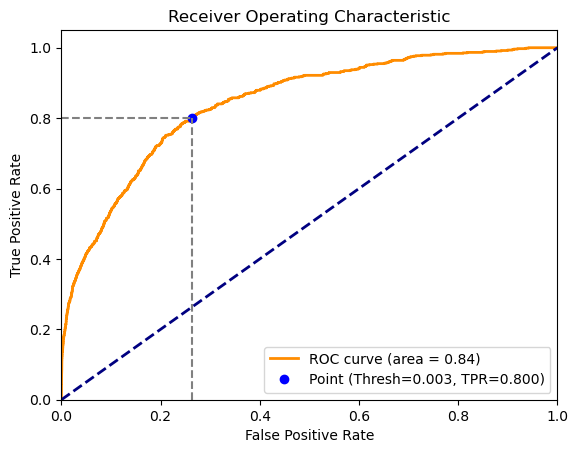

In [37]:
y_validation_predictions_proba = best_ensemble_pipeline.predict_proba(X_validation_predictions)
plot_roc_curve(y_validation,y_validation_predictions_proba[:,1],point_tprs=[0.8])

In [40]:
## Predictions with new threshold ##
threshold = 0.0029

y_validation_predictions = (best_ensemble_pipeline.predict_proba(X_validation_predictions)[:,1] > threshold).astype(int)
accuracy = accuracy_score(y_validation, y_validation_predictions)
print("Validation set accuracy:", accuracy)
print('f1 score: ',f1_score(y_validation, y_validation_predictions))

Validation set accuracy: 0.7410891994832872
f1 score:  0.024930053868960623
